# Práctica 2

## Preparación de entorno

In [73]:
import numpy as np
import keras as ker
import matplotlib.pyplot as plt 
import pandas as pd
import sklearn as sk
from IPython.display import clear_output # Limpiar output
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

## SETUP

### Lectura y limpieza dataset

In [74]:
cancer = pd.read_csv("cancer_dataset.csv", encoding = 'latin_1', sep = ',')
cancer = cancer.drop(columns=['id'], axis=1) # No sirve

aleatorizar = True # TOCAR

cancerentren, cancertest = train_test_split(cancer, test_size = 0.20, shuffle=aleatorizar) # El entreno es el 70% y el conjunto prueba 20%
#cancerentrenamiento,cancervalidar = train_test_split(cancerentren, test_size = 0.30, shuffle=aleatorizar) # El entrenamiento se hará con el 70% de los datos y validará con el 30%
cancerentrenamiento = cancerentren
# Generamos las salidas de las diferentes listas
esperadas_entrenamiento = cancerentrenamiento.pop("diagnosis")
#esperadas_validacion = cancervalidar.pop("diagnosis")
esperadas_test = cancertest.pop("diagnosis")

### Variables a definir

In [75]:
# Normalización entradas en base a máximo y mínimo (máximo es 1 - mínimo es 0)

cancerentrenamiento = (cancerentrenamiento - cancerentrenamiento.min()) / (cancerentrenamiento.max() - cancerentrenamiento.min())
#cancervalidar = (cancervalidar - cancervalidar.min()) / (cancervalidar.max() - cancervalidar.min())
cancertest = (cancertest - cancertest.min()) / (cancertest.max() - cancertest.min())

entradasE =  cancerentrenamiento.to_numpy() # Las 30 posibles variables
esperadasE = esperadas_entrenamiento.to_numpy() # Array de B/M con el diagnóstico

#entradasV = cancervalidar.to_numpy() 
#esperadasV = esperadas_validacion.to_numpy()

entradasT = cancertest.to_numpy() 
esperadasT = esperadas_test.to_numpy()

# Categorizamos el diagnostico de entreno (M = 1 / B = 0)
label_encoder = LabelEncoder()
esperadasE = label_encoder.fit_transform(esperadasE)

# Categorizamos el diagnostico de predicción (M = 1 / B = 0)
#esperadas_validacion = label_encoder.fit_transform(esperadas_validacion)
esperadasT = label_encoder.fit_transform(esperadasT)
#esperadasV = label_encoder.fit_transform(esperadasV)


nNeuronasCapaOculta = 12 # Tocar
nCapasOcultas = 10 # Tocar
Epoch = 500 # Tocar
tam_entrada = cancerentrenamiento.shape[1] # Tamaño de la capa de entrada = columnas
automatizador = False # Ejecutar el automatizador para encontrar los parametros que mas se ajustan a los datos

def validar_neuronas_oculta(M,N,n): # Empleamos esta funcion para validar que las neuronas de la capa oculta cumplen con la regla aprendida en clase
    # La regla a validar es (M/2N < n < 2M/N)
    # Siendo M: ejemplos de entrenamiento // N: neuronas de entrada // n: neuronas de la capa oculta
    if((M/(2*N)) < n and n < ((2*M)/N)):
        return print("Neuronas de la capa oculta cumple regla") # validamos
    return print("Neuronas de la capa oculta no cumple regla")

#validar_neuronas_oculta(cancerentrenamiento.shape[0],tam_entrada,nNeuronasCapaOculta)

### Creación y ajuste de la red

In [76]:
def initRed(nNeuronasCapaOculta,nCapasOcultas, tam_entrada):
    MLP = ker.Sequential() # Creamos el modelo vacío

    # Añadimos la primera capa (tecnicamente dos, la de entrada (con la variable input_dim) y la oculta)
    MLP.add(ker.layers.Dense(nNeuronasCapaOculta, input_dim = tam_entrada, activation='relu'))

    # Añadimos tantas capas ocultas extra como queramos (siempre como mínimo hay 1, la creada anteriormente)
    for i in range(nCapasOcultas):
        MLP.add(ker.layers.Dense(nNeuronasCapaOculta, activation='relu'))

    # Añadimos la capa de salida
    MLP.add(ker.layers.Dense(1,activation='sigmoid')) 

    # MLP.summary()

    # Por último tenemos que configurar el modelo antes de entrenarlo con lo dicho en el enunciado
    # Optimizador: Adam
    # Función error: Mean Squared Error
    # Metricas = Binary accuracy porque nos da el número de precisión de la red
    MLP.compile(optimizer='adam',loss='mean_squared_error',metrics=["binary_accuracy"])
    return MLP


### Entrenamiento de la red

In [77]:
def entrenar(MLP,Epoch,entradas,esperadas):#,entradasVal,esperadasVal):
    # Por último entrenamos la red con el epoch (nº iteraciones)
    output_fit = MLP.fit(entradas,esperadas,validation_split=0.30,epochs=Epoch,verbose = 0) #validation_data=() % 30% de los datos se usan para validar
    return output_fit

### Calidad de la red

In [78]:
def pintarExact(output_fit):
    print(output_fit.history.keys())
    # Pintamos las tanto la loss como la accuracy
    plt.plot(output_fit.history['loss'])
    plt.plot(output_fit.history['binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Error', 'Exactitud'], loc='lower left')
    plt.show()

### Prueba de la red

In [79]:
def prueba(MLP,cancerpredecir,esperadas_predecir):
    # Una vez tenemos entrenada la red, probamos todas las entradas y vemos si funciona
    i = 0
    fallos = 0
    resultados = MLP.predict(cancerpredecir).round()
    error = ""
    print("================ EXACTITUD ================")
    for resultado in resultados:
        if(resultado != esperadas_predecir[i]):
            fallos += 1
            error = "ERROR"
        print("PREDICHO ->", resultado, " ESPERADO ->", esperadas_predecir[i], error)
        i += 1
        error = ""
    print("Número de fallos: ", fallos, " de ", cancerpredecir.shape[0], "porcentaje de fallo: ", fallos/cancerpredecir.shape[0])

def evaluar(MLP,entradas,esperadas):
    # Evaluamos el modelo
    print("Datos evaluados")
    evaluar = MLP.evaluate(entradas, esperadas,verbose=0)
    print("Error, Exactitud:", evaluar)
    return evaluar

def evaluarAuto(MLP,entradas,esperadas):
    return MLP.evaluate(entradas, esperadas,verbose=0)

Neuronas de la capa oculta cumple regla
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


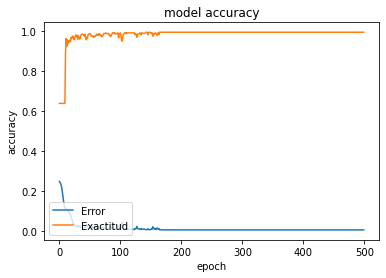

In [80]:
if not automatizador:
    validar_neuronas_oculta(cancerentrenamiento.shape[0],tam_entrada,nNeuronasCapaOculta)
    MLP = initRed(nNeuronasCapaOculta,nCapasOcultas, tam_entrada)
    output_fit = entrenar(MLP,Epoch,entradasE,esperadasE)#,entradasV,esperadasV) # conjunto de entrenamiento junto con el conjunto de validación
    pintarExact(output_fit)

In [81]:
if not automatizador:
    evaluacion = evaluar(MLP,entradasT,esperadasT)  # conjunto de prueba
    #prueba(MLP,entradasT,esperadasT) # conjunto de prueba

Datos evaluados
Error, Exactitud: [0.11345714330673218, 0.8859649300575256]


In [82]:
# neuronas
if automatizador:
    neuronas = [i for i in range(5,40,5)]
    capas = [i for i in range(2,20,4)]
    epochs = [i for i in range(50,1000,25)]
    precision = 5
    # Una vez hemos inicializado, podemos empezar a iterar con las listas creadas para encontrar la mejor configuración para los datos 
    err = []
    ex = []
    outputErr = [err,ex]
    for neurona in neuronas:
        print("Numero de neuronas:",neurona,end="\r")
        for i in range(precision):
            MLP = initRed(neurona,capas[int(len(capas)/2)], tam_entrada)
            output_fit = entrenar(MLP,epochs[int(len(epochs)/2)],entradasE,esperadasE)
            error,exact = evaluarAuto(MLP,entradasT,esperadasT)
            err.append(error)
            ex.append(exact)
        outputErr[0].append(np.mean(err))
        outputErr[1].append(np.mean(exact))
    # Ahora pintamos la grafica para ver el error y la precisión
    plt.title('Precision')
    plt.plot(outputErr[0])
    plt.plot(outputErr[1])
    plt.legend(['Error', 'Exactitud'], loc='center right')
    plt.ylabel('Error & Exactitud')
    plt.xlabel('Numero de neuronas por capa')
    plt.show()

In [83]:
# capas
if automatizador:
    neuronas = [i for i in range(5,40,5)]
    capas = [i for i in range(2,20,4)]
    epochs = [i for i in range(50,1000,25)]
    precision = 5
    # Una vez hemos inicializado, podemos empezar a iterar con las listas creadas para encontrar la mejor configuración para los datos 
    err = []
    ex = []
    outputErr = [err,ex]
    for capa in capas:
        print("Numero de capas:",neurona,end="\r")
        for i in range(precision):
            MLP = initRed(neuronas[2],capa, tam_entrada) #int(len(neuronas)/2)
            output_fit = entrenar(MLP,epochs[int(len(epochs)/2)],entradasE,esperadasE)
            error,exact = evaluarAuto(MLP,entradasT,esperadasT)
            err.append(error)
            ex.append(exact)
        outputErr[0].append(np.mean(err))
        outputErr[1].append(np.mean(exact))
    # Ahora pintamos la grafica para ver el error y la precisión
    plt.title('Precision')
    plt.plot(outputErr[0])
    plt.plot(outputErr[1])
    plt.legend(['Error', 'Exactitud'], loc='center right')
    plt.ylabel('Error & Exactitud')
    plt.xlabel('Numero de capas ocultas')
    plt.show()

In [84]:
# epoch
if automatizador:
    neuronas = [i for i in range(5,40,5)]
    capas = [i for i in range(2,20,4)]
    epochs = [i for i in range(50,1000,25)]
    precision = 5
    # Una vez hemos inicializado, podemos empezar a iterar con las listas creadas para encontrar la mejor configuración para los datos 
    err = []
    ex = []
    outputErr = [err,ex]
    for epoch in epochs:
        print("Epoch:",epoch,end="\r")
        for i in range(precision):
            MLP = initRed(neuronas[4],capas[2], tam_entrada)#int(len(neuronas)/2)    int(len(capas)/2)
            output_fit = entrenar(MLP,epoch,entradasE,esperadasE)
            error,exact = evaluarAuto(MLP,entradasT,esperadasT)
            err.append(error)
            ex.append(exact)
        outputErr[0].append(np.mean(err))
        outputErr[1].append(np.mean(exact))
    # Ahora pintamos la grafica para ver el error y la precisión
    plt.title('Precision')
    plt.plot(outputErr[0])
    plt.plot(outputErr[1])
    plt.legend(['Error', 'Exactitud'], loc='center right')
    plt.ylabel('Error & Exactitud')
    plt.xlabel('Epoch')
    plt.show()

# Influencia de las variables y reducción de dimensionalidad

## Funciones para automatizar

In [85]:
def dataset(columna, cancer_d):  # Pasamos la columna a eliminar
    
    if(columna != "0"):
        cancer_d = cancer_d.drop([columna], axis=1)

    cancerentren_aux, nada = train_test_split(cancer_d, test_size = 0.20, shuffle=aleatorizar) # El entreno es el 70% y el conjunto prueba 20%

    esperadas_entrenamiento_aux = cancerentren_aux.pop("diagnosis")

    cancerentren_aux = (cancerentren_aux - cancerentren_aux.min()) / (cancerentren_aux.max() - cancerentren_aux.min())

    entradasE_aux =  cancerentren_aux.to_numpy() # Las 30 posibles variables
    esperadasE_aux = esperadas_entrenamiento_aux.to_numpy() # Array de B/M con el diagnóstico
    # Categorizamos el diagnostico de entreno (M = 1 / B = 0)
    esperadasE_aux = label_encoder.fit_transform(esperadasE_aux)
    return cancer_d, entradasE_aux, esperadasE_aux

## Ejecución

In [86]:
acuracy_red = evaluacion[1]
acuracy_red_porcentaje = float(acuracy_red) - (float(acuracy_red) * (10. / 100.))
acuracy_pequeño = 100

columnas_eliminar = []
columna_eliminar = ""
seguir = 1

i = 0

cancer_aux = cancer.copy()
columna = "0"

tam_red = 1

while (seguir):

    ker.backend.clear_session()
    red = initRed(nNeuronasCapaOculta,nCapasOcultas,tam_entrada-tam_red)

    seguir = 0
    cancer_aux, entradasE_aux, esperadasE_aux = dataset(columna, cancer_aux)
    i = 0

    for columnas in cancer_aux:
        if(columnas != "diagnosis"):
            
            cancer_temporal, entradasE_temporal, esperadasE_temporal = dataset(columnas, cancer_aux)
            output_fit_temporal = entrenar(red,Epoch,entradasE_temporal,esperadasE_temporal)
            entrada_temporal = np.delete(entradasT,i,1)
            acuracy_temporal = red.evaluate(entrada_temporal, esperadasT,verbose=0)
            acuracy_temporal = acuracy_temporal[1]

            print("Columna ", i, " a eliminar", columnas," con accuracy ",acuracy_temporal)
            if((acuracy_temporal > acuracy_red_porcentaje) and (acuracy_temporal < acuracy_pequeño)): # Así sacamos la columna del error más pequeño
                seguir = 1
                acuracy_pequeño = acuracy_temporal
                columna_eliminar = columnas
            print("La columna ", columna_eliminar, "es la acuracy más pequeño con ", acuracy_pequeño)
            i += 1

    clear_output(wait=True) # Limpiamos output

    if(seguir): # El accuracy tiene que ser mayor que el 90% de accuracy general para seguir
        # Si es asi eliminamos la columna y generamos 
        print("Eliminamos la columna ", columna_eliminar, " con accuracy ", acuracy_pequeño, " frente a accuracy antiguo ", acuracy_red_porcentaje)
        columna = columna_eliminar
        columnas_eliminar.append(columna)
        tam_red += 1

print("Se eliminaron las siguientes columnas: ", columnas_eliminar)
print("Consiguiendo la diferencia de accuracy antiguo ", acuracy_red, " a accuracy nuevo ", acuracy_pequeño)

Eliminamos la columna  area_worst  con accuracy  0.9210526347160339  frente a accuracy antiguo  0.7973684370517731


ValueError: in user code:

    /home/gonzalo/anaconda3/envs/tensorflow-environment/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /home/gonzalo/anaconda3/envs/tensorflow-environment/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/gonzalo/anaconda3/envs/tensorflow-environment/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/gonzalo/anaconda3/envs/tensorflow-environment/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/gonzalo/anaconda3/envs/tensorflow-environment/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/gonzalo/anaconda3/envs/tensorflow-environment/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1217 run_step  **
        outputs = model.test_step(data)
    /home/gonzalo/anaconda3/envs/tensorflow-environment/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1183 test_step
        y_pred = self(x, training=False)
    /home/gonzalo/anaconda3/envs/tensorflow-environment/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/gonzalo/anaconda3/envs/tensorflow-environment/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_12 is incompatible with the layer: expected axis -1 of input shape to have value 28 but received input with shape (None, 29)
